# GenePy

## This is a python module to analysis gene expression profile from the ncbi GEO database.

Goal is to build a flexible tookbox for gene expression profile analysis using machine learning. Although there are similar toolboxes, GenePy will be more focused on flexibility and being user-friendly. So the researches from all over the world can openly access to this tool and use different machine learning models for analysis.

## Parser

    
    This module downloads gene expression profile from NCBI GEO FTP website and parses it
    Parameters
    ----------
    link  : str
    This is the link to GEO soft_full.gz file on NCBI website
    data_dim  : int
    This gets number of genes needed to be considered ( data_dim = 10; only first 10 genes from the
    top of the input file will be considered in parsing data and data_dim = None means all the data)

    Returns
    -------
    dataset : numpy array
    dataset is a numpy array. Each row represents one cell gene expression data, the i_th column
    from the left shows the i_th gene expression values from the top in row input data table and
    the last column on the right shows the subset description type 0 being the first one showing 
    in the input file. 

In [2]:
def read(link, data_dim):
    import gzip
    import numpy as np
    import pandas as pd
    import pickle
    from matplotlib.pyplot import plot as plt
    import os
    
    file_name = link.split('/')[-1]
    dir_root = os.listdir()

    if 'temp' not in dir_root: 
        os.mkdir('temp')
    else:
        pass 

    dir_temp = os.listdir('temp/')

    # If the input file does not exist then it will download the file, otherfiles, 
    # the code will use the existing file
    if file_name not in dir_temp: 
        import urllib.request
        urllib.request.urlretrieve(link, 'temp/' + file_name)[0]

    else:
        pass

    # Data input dimension to simplify is defined (None => imports all the genes 
    # unless number of genes are declared)

    with gzip.open('temp/' + file_name, 'rt') as f:
        #    sd: subset description
        #    si: subset id
        #    ge: gene expression
        sd, si, ge = [], [], []
        
        #    Obtain subset description
        for line in f:
            if "!subset_description" in line:
                sd.append(line.split('=')[1].strip())
                
            elif "!subset_sample_id" in line:
                si.append(line.split('=')[1].strip().split(','))
                
            elif "!dataset_table_begin" in line:
                break
            
        subset_number = sum(len(sd) for sd in si)
        #  Read the gene info table

        for line in f:
            if "!dataset_table_begin" in line:
                break            
    
            elif "!dataset_table_end" in line:
                break
    
            ge.append(line.split()[:2 + subset_number])
    
    ge = pd.DataFrame(ge)
    new_header = ge.iloc[0]
    ge.columns = new_header
    ge = ge[1:]


    '''
    #   Here, we create a temporary directory to store needed files
    ge.to_pickle('temp/ge')
    pickle.dump(sd , open( 'temp/sd', 'wb' ))
    pickle.dump(si , open( 'temp/si', 'wb' ))
    '''


    ge_array = np.array(ge)
    d = ge_array[:, 2:].astype(float)

    # Convert numpy array to training format for SVM solver
    data = []
    for i in range(len(d[0,:])):
        data.append(d[:data_dim,i])
    data = np.array(data)

    #   Assign numbers to subset types and make a target vector for classification
    labels = []
    for i in range(0, len(sd)):
        labels.append(len(si[i]) * [i])
    
    #   Merge the target groups (each type is a list in python, 
    #   this part merges the parts to have unit target vector)
    label_tmp = []
    for j in range(len(labels)):
        label_tmp += labels[j]
    labels = np.array(label_tmp)

    # dimension of input gene expression
    label_dimension = len(ge_array[0,2:])
    labels = labels.reshape((label_dimension,1))


    #   This line joins the data and labels as a new 2D array
    dataset = np.concatenate((data, labels), axis=1)

    #   This part randomly shuffles the data to be ready for training and testing purposes
    np.random.shuffle(dataset)

    # This file will be saved into temp folder in case of any need for review
    np.savetxt('temp/dataset.csv', dataset, fmt='%.3f', delimiter=',', newline='\n', header='')

    # This binary file will be save in the temp folder for faster load in other modules
    np.save('temp/dataset_binary', dataset)

    return dataset

## Parameters
    This module has all the parameters and values

    Parameters
    ------

    Returns
    -------
    parameters : dict
        Return a dictionary of all the parameters and the values

In [3]:
def database():
    #   Server parameters
    parameters = {'directory_1': 'local_directory',
                  'directory_2': 'directory_on_server',
                  'key_address': 'full_address_to_the_ssh_key_file',
                  'user': 'username', 'server': 'server address',

                  #   Parsing parameters
                  'link': 'ftp://ftp.ncbi.nlm.nih.gov/geo/datasets/GDS1nnn/GDS1615/soft/GDS1615_full.soft.gz',
                  'input_dim': 500,\

                  #   Autoencoder parameters
                  'epoch': 50, 'batch': 200, 'latent': 30, 'encoder_o': 100,
                  'encoder_i': 50, 'decoder_i': 50, 'decoder_o': 100, 'train_percent': 75,
                  'lam': 0.0001, 'loss_plot': False, 'norm_order': 10,\

                  #   SVM parameters
                  'train_percent': 75, 'gamma': 0.0001, 'c': 1000000}

    keys = list(parameters.keys())
    values = list(parameters.values())

    #   converts the long dictionary to list of small dictionaries consist of a variable and values
    packed = []
    for i in range(len(keys)):
        key = [keys[i]]
        value = [values[i]]
        packed.append(dict(zip(key, value)))

    return parameters, packed

    This following function changes the parameter format and prepares to run the model

    Parameters
    ----------
    parameter: str
        Parameters name which is to be changed
    value: NA
        Value of the parameter which is changing

    Returns
    -------
    parameters : dict
        Return a dictionary of all the parameters and the values

In [4]:
def parametrize(parameter, value):

    #   Read the database as a big dictionary and change the values and retuns big
    #   dictionary and list of small dictionatries
    parameters, _ = database()

    parameters[parameter] = value

    keys = list(parameters.keys())
    values = list(parameters.values())

    #   converts the long dictionary to list of small dictionaries consist of a variable and values
    packed = []
    for i in range(len(keys)):
        key = [keys[i]]
        value = [values[i]]
        packed.append(dict(zip(key, value)))

    return parameters, packed

## Core
This module handles more general functions such as logging the processes and cleanup previous files from last run.

In [5]:
import shutil

def log(entry):
    '''
    This function logs epecific event to a file 'log.txt'

    Parameters
    -----

    Returns
    -----

    '''
    with open('temp/log.txt', 'a') as file:
        file.writelines(entry + '\n')


def clean():
    '''
    This function cleans the temp folder from last run

    Parameters
    -----

    Returns
    -----

    '''
    try:
        shutil.rmtree('temp')
    except OSError:
        pass

## Deep Autoencoder (Data compression)

    This module is autoencoder neural network which gets input data and
    reduces the dimension and returns similar data to the input. Data 
    compression is useful for future data manipulation.

    Parameters
    ----------
    epoch  : int
        Epoch gets the epoch number of the neural network passed through
        the neural network in each iteration
    batch  : int
        Batch number of the neural network determines how many times all 
        the data will be passed through the neural network
    latent : int
        Latent vector dimension shows the size of buttleneck (compressed data)
    encoder_o : int
        Size of outer encoder hidden layer of the neural network close to the 
        input
    encoder_i : int
        size of inner encoder hidden layer of the neural network close to the 
        buttleneck
    decore_i : int
        size of inner decoder hidden layer of the neural network close to the 
        buttleneck
    decore_o : int
        size of outer decoder hidden layer of the neural network close to the 
        output
    train_percent : float
        (The value will be between 0 and 100) shows what fraction of the dataset
        will be used for training and the rest for testing
    lam : float
        The coefficient of regularization for the autoencoder model
    norm_order: int 
        keras data normalization parameter
    loss_plot : Boolean
        If True plots the loss function and if False, does not plot that

    Returns
    -------
    input : list
        gives all the inputs used for training
    latent vector : list
        Latent vector, the compressed representation of the input
    reconstructed: list
        Gives the reconstructed data from the input  
    cell_types: list
        Gives a list of integers represent cell types for the given input data
    auto_runtime : float
        Training runtime in seconds
    auto_err: float
        The autoencoder average error (%)

In [6]:
def autoencoder (epoch, batch, latent, encoder_o, encoder_i, \
    decoder_i, decoder_o, train_percent, lam, norm_order, loss_plot):

    #   Import required libraries
    from keras import callbacks
    from keras.layers import Input, Dense
    from keras.models import Model
    from keras.utils import normalize
    from keras import regularizers
    import tensorflow as tf
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib.pyplot import draw, show
    import pickle
    import time

    #   starting time is measured to compare performance"""
    time_start = time.time()

    #   Importing the database parsed from the input file
    dataset = np.load('temp/dataset_binary.npy')

    #   PErforme log transform and normalization before analysis
    input_data =np.log(dataset[:,:-1]) / np.log(2)
    input_data = normalize(input_data, axis=0, order=norm_order)
    input_size = len(input_data[0, :])

    #   Split cell types list from the raw data and keep it
    labels = dataset[:,-1]

    #   Split training and testing data from the input dataset
    percent_training = int(len(input_data[:, 0]) * (train_percent/100))
    X_train = input_data[:percent_training,:input_size]
    L_train = dataset[:percent_training, -1]
    X_test = input_data [percent_training:,:input_size]
    L_test = dataset[percent_training:, -1]

    #   Define network parameters
    epoch_size = epoch
    batch_size = batch
    latent_dim = latent

    #   Lambda coefficnet of l2 regulizor of the keras
    lam = lam

    ### Building the neural network layers
    encoder_o = encoder_o
    encoder_i = encoder_i
    decoder_i = decoder_i
    decoder_o = decoder_o

    #   building the input layer
    input_gene_expression = Input(shape=(input_size,))

    """#### Encoder layer
    The encoder layer will connet input layer to the latent vector.
    In order to avoid ovefitting, l2 regularization methos is used which 
    changes loss function for larger weights.
    """
    encoded = Dense(encoder_o, kernel_regularizer=regularizers.l2(lam), \
        activation=tf.nn.relu)(input_gene_expression)
    encoded = Dense(encoder_i, kernel_regularizer=regularizers.l2(lam), \
        activation=tf.nn.relu)(encoded)
    encoded = Dense(latent_dim, kernel_regularizer=regularizers.l2(lam), \
        activation=tf.nn.relu)(encoded)

    """#### Decoder layer
    Decoder layer is defined same as encoder layer but, it connects latent space
     to the output layer.
    """
    decoded = Dense(decoder_i, kernel_regularizer=regularizers.l2(lam), \
        activation =tf.nn.relu)(encoded)
    decoded = Dense(decoder_o, kernel_regularizer=regularizers.l2(lam), \
        activation =tf.nn.relu)(decoded)
    decoded = Dense(input_size, kernel_regularizer=regularizers.l2(lam), \
        activation =tf.nn.sigmoid)(decoded)

    """
    The autoencoder model is created mapping input data to reconstructed data 
    similar to the input.
    """
    autoencoder = Model(input_gene_expression, decoded)

    """
    Encoder model is created to show the latent vectors
    """
    encoder = Model(input_gene_expression, encoded)
    
    """
    Loss function of variational autoencoder is defined as the distance between
    input and output using mean squared error (MSE). The optimizer "adam" is 
    then used to minimize the MSE function
    """
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=\
        ['accuracy'])
    

    """
    Training the autoencoder model: Network dimensions, batch and epoch sizes 
    and training and testing datasets are used to train the model
    """

    #   This section defins the plot and callback functions to track training
    class PlotLosses(callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.i = 0
            self.x = []
            self.losses = []
            self.val_losses = []
            
            self.fig = plt.figure()
            
            self.logs = []

        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.i += 1

            if loss_plot:
                plt.plot(self.x, self.losses, label="Training loss", c = 'b', \
                    linestyle = '-')
                plt.plot(self.x, self.val_losses, label="Validation loss",\
                     c = 'b', linestyle = '-.')
                plt.pause(0.01)
                plt.title('Training loss: ---, Validation loss: -.-.')
                plt.xlabel('Epoch number')
                plt.ylabel('MSE value')

            else:
                pass


    time_start = time.time()
    autoencoder.fit(X_train, X_train, epochs=epoch_size, batch_size=batch_size,\
                    shuffle=True, callbacks=[PlotLosses()], validation_data=\
                        (X_test, X_test), verbose=1)


    #   Build reconstructed testing layer to measure the autoencoder's error
    reconstructed_test = autoencoder.predict(X_test)
 
    #   Autoencoder training runtime is calculated
    time_end = time.time()
    auto_runtime = time_end - time_start


    #   Autoencoder error is defined
    diff = abs(X_test - reconstructed_test)
    diff_mean = np.mean(diff)
    mean = np.mean(abs(X_test))
    auto_err = diff_mean / mean

    #   show() function, keeps the plot open until the computation is finished
    if loss_plot:
        plt.show()
    else:
        pass

    #   Build latent and reconstruction tensors
    latent = encoder.predict(input_data)
    reconstructed = autoencoder.predict(input_data)

    #   exporting latent file and labels for classifier
    pickle.dump(latent, open('temp/latent', 'wb'))
    pickle.dump(labels, open('temp/labels', 'wb'))
    plt.close()
    
    return input_data, latent, reconstructed, labels, auto_runtime, auto_err

## Support Vector Machine (Classifier)
    This module uses support vector machine (SVM) to classify the cell types 
    based on their compressed gene expression profile (latent vectors)

    Parameters
    ----------
    gamma  : float
        C-support nonlinear SVM Parameter (Gamma)
    c : float
        C-support nonlinear SVM Parameter (C)
    percent : float
        show what percentage is used for training (between 0 and 100)

    Returns
    -------
    label_predicted: list
        List of label predictions
    svm_runtime : loat
        SVM runtime in seconds
    svm_err : float
        SVM average error (%)

In [7]:
def classify (gamma, c, train_percent):
    #   Import required libraries
    from sklearn import svm
    import numpy as np
    import pickle
    import time


    #   Start time to measure SVM runtime
    time_start = time.time()

    #   Import latent data and labels (created by the autoencoder)
    latent = pickle.load(open('temp/latent', 'rb'))
    labels = pickle.load(open('temp/labels', 'rb'))

    #   Prepare testing and training datasets
    input_size = len(latent[0, :])
    percent_training = int(len(latent[:, 0]) * (train_percent/100))
    latent_train = latent[:percent_training,:input_size]
    label_train = labels[:percent_training]
    latent_test = latent[percent_training:,:input_size]
    label_test = labels[percent_training:]

    #   SVM training function
    def cell_classifier(input):
        model = svm.SVC(gamma=gamma, C=c)
        model.fit(latent_train, label_train)
        output = model.predict(input)
        return output

    #   Make predictions based on the testing latent vectors
    label_predicted = cell_classifier(latent_test)

    #   Classification error calculation
    missclassified = np.count_nonzero(label_test - label_predicted)
    svm_err = missclassified / len(label_test)


    #   SVM Runtime is measured
    time_end = time.time()
    svm_runtime = time_end - time_start

    return label_predicted, svm_runtime, svm_err

## Sensitivity

This module includes sensitivity analyis function to measure autoencoder and SVM
accuracy and performance and hanges a parameters by the values provided and returns 
autoencoder and SVM runtime and errors.

    parameters
    ----------
    test_samples: list
        list of dictionaries for each parameter to test
        (i.e. [{'epoch':range(10,30,10)}, {'batch':range(500,700,100)}])

    Returns
    -------
    [auto_runtime, auto_err, svm_runtime, svm_err]
    
    where:

    auto_runtime : float
        Autoencoder runtime in seconds
    auto_err : float
        Autoencoder average error in percentage
    svm_runtime : float
        SVM runtime in second
    svm_err : float
        SVM average error in percentage

In [8]:
def test(test_samples):

    #   Import required libraries
    import numpy as np

    for test in test_samples:
        parameter, values = list(test.keys())[0], list(test.values())[0]
        #   Run the functions to assess performance, the inputs are passed in shape of dictionary
        def whole_model(**kwargs):
            read(kwargs['link'], kwargs['input_dim'])
            _, _, _, _, auto_runtime, auto_err = \
                autoencoder(kwargs['epoch'], kwargs['batch'], kwargs['latent'],
                            kwargs['encoder_o'], kwargs['encoder_i'], kwargs['decoder_i'], 
                            kwargs['decoder_o'], kwargs['train_percent'], kwargs['lam'], 
                            kwargs['norm_order'], kwargs['loss_plot'])
            _, svm_runtime, svm_err = classify(kwargs['gamma'], kwargs['c'], kwargs['train_percent'])
            return auto_runtime, auto_err, svm_runtime, svm_err


        auto_runtime, auto_err, svm_runtime, svm_err = [], [], [], []

        for v in values:
            parameters, _ = parametrize(parameter, v)
            #   Here **, unzips parameters dictionary to argument before passing to the function
            a_runtime, a_err, s_runtime, s_err = whole_model(**parameters)
            auto_runtime.append(a_runtime)
            auto_err.append(a_err)
            svm_runtime.append(s_runtime)
            svm_err.append(s_err)
            
    return auto_runtime, auto_err, svm_runtime, svm_err

## Main

In this section, we can plot some of the analysis done by the autoencoder-SVM model on gene profile data.

In [9]:
#   This method cleans the remnant files from the last run
clean()

#   Here, we define the parameters and values to investiate
latent_list = range(10,100,2)
test_params = [{'latent':latent_list}]

#   Perform sensitivity analysis
file = test(test_params)



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0640 - acc: 0.0000e+00 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 113us/step - loss: 0.0632 - acc: 0.0000e+00 - val_loss: 0.0623 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 95us/step - loss: 0.0623 - acc: 0.0000e+00 - val_loss: 0.0613 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 74us/step - loss: 0.0613 - acc: 0.0000e+00 - val_loss: 0.0603 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 74us/step - loss: 0.0602 - acc: 0.0000e+00 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 84us/step - loss: 0.0591 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Ep

Epoch 5/50
95/95 [==============================] - 0s 95us/step - loss: 0.0607 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 105us/step - loss: 0.0594 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+00
Epoch 7/50
95/95 [==============================] - 0s 74us/step - loss: 0.0580 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 74us/step - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0551 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 105us/step - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 126us/step - loss: 0.0534 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 105us/step - loss: 0.0518 - acc: 0.0000e+00 - val_loss: 0.0503 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==

Epoch 14/50
95/95 [==============================] - 0s 84us/step - loss: 0.0481 - acc: 0.0000e+00 - val_loss: 0.0464 - val_acc: 0.0000e+00
Epoch 15/50
95/95 [==============================] - 0s 74us/step - loss: 0.0466 - acc: 0.0000e+00 - val_loss: 0.0450 - val_acc: 0.0000e+00
Epoch 16/50
95/95 [==============================] - 0s 95us/step - loss: 0.0453 - acc: 0.0000e+00 - val_loss: 0.0438 - val_acc: 0.0000e+00
Epoch 17/50
95/95 [==============================] - 0s 95us/step - loss: 0.0440 - acc: 0.0000e+00 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 18/50
95/95 [==============================] - 0s 116us/step - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0415 - val_acc: 0.0000e+00
Epoch 19/50
95/95 [==============================] - 0s 105us/step - loss: 0.0417 - acc: 0.0000e+00 - val_loss: 0.0405 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [==============================] - 0s 84us/step - loss: 0.0407 - acc: 0.0000e+00 - val_loss: 0.0395 - val_acc: 0.0000e+00
Epoch 21/50
95/95 

Epoch 23/50
95/95 [==============================] - 0s 105us/step - loss: 0.0390 - acc: 0.0000e+00 - val_loss: 0.0381 - val_acc: 0.0000e+00
Epoch 24/50
95/95 [==============================] - 0s 95us/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0373 - val_acc: 0.0000e+00
Epoch 25/50
95/95 [==============================] - 0s 84us/step - loss: 0.0373 - acc: 0.0000e+00 - val_loss: 0.0365 - val_acc: 0.0000e+00
Epoch 26/50
95/95 [==============================] - 0s 95us/step - loss: 0.0365 - acc: 0.0000e+00 - val_loss: 0.0357 - val_acc: 0.0000e+00
Epoch 27/50
95/95 [==============================] - 0s 105us/step - loss: 0.0357 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 28/50
95/95 [==============================] - 0s 95us/step - loss: 0.0350 - acc: 0.0000e+00 - val_loss: 0.0343 - val_acc: 0.0000e+00
Epoch 29/50
95/95 [==============================] - 0s 95us/step - loss: 0.0343 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 30/50
95/95 

Epoch 32/50
95/95 [==============================] - 0s 105us/step - loss: 0.0314 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 33/50
95/95 [==============================] - 0s 74us/step - loss: 0.0308 - acc: 0.0000e+00 - val_loss: 0.0299 - val_acc: 0.0000e+00
Epoch 34/50
95/95 [==============================] - 0s 105us/step - loss: 0.0302 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 35/50
95/95 [==============================] - 0s 84us/step - loss: 0.0296 - acc: 0.0000e+00 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 36/50
95/95 [==============================] - 0s 74us/step - loss: 0.0290 - acc: 0.0000e+00 - val_loss: 0.0282 - val_acc: 0.0000e+00
Epoch 37/50
95/95 [==============================] - 0s 84us/step - loss: 0.0284 - acc: 0.0000e+00 - val_loss: 0.0277 - val_acc: 0.0000e+00
Epoch 38/50
95/95 [==============================] - 0s 95us/step - loss: 0.0279 - acc: 0.0000e+00 - val_loss: 0.0271 - val_acc: 0.0000e+00
Epoch 39/50
95/95 

Epoch 41/50
95/95 [==============================] - 0s 116us/step - loss: 0.0271 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 42/50
95/95 [==============================] - 0s 95us/step - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0260 - val_acc: 0.0000e+00
Epoch 43/50
95/95 [==============================] - 0s 116us/step - loss: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 44/50
95/95 [==============================] - 0s 116us/step - loss: 0.0256 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 45/50
95/95 [==============================] - 0s 95us/step - loss: 0.0251 - acc: 0.0000e+00 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 46/50
95/95 [==============================] - 0s 95us/step - loss: 0.0246 - acc: 0.0000e+00 - val_loss: 0.0241 - val_acc: 0.0000e+00
Epoch 47/50
95/95 [==============================] - 0s 95us/step - loss: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0000e+00
Epoch 48/50
95/95

95/95 [==============================] - 0s 74us/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 50/50
95/95 [==============================] - 0s 105us/step - loss: 0.0236 - acc: 0.0000e+00 - val_loss: 0.0232 - val_acc: 0.0000e+00
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 1s 10ms/step - loss: 0.0682 - acc: 0.0000e+00 - val_loss: 0.0672 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 170us/step - loss: 0.0672 - acc: 0.0000e+00 - val_loss: 0.0662 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 84us/step - loss: 0.0662 - acc: 0.0000e+00 - val_loss: 0.0651 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 74us/step - loss: 0.0651 - acc: 0.0000e+00 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 105us/step - loss: 0.0640 - acc: 0.0000e+00 - val_loss: 0.0628 - val_acc: 0

Epoch 7/50
95/95 [==============================] - 0s 95us/step - loss: 0.0614 - acc: 0.0000e+00 - val_loss: 0.0602 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 84us/step - loss: 0.0600 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 84us/step - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 74us/step - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 116us/step - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==============================] - 0s 95us/step - loss: 0.0536 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 13/50
95/95 [==============================] - 0s 95us/step - loss: 0.0520 - acc: 0.0000e+00 - val_loss: 0.0507 - val_acc: 0.0000e+00
Epoch 14/50
95/95 [===

Epoch 16/50
95/95 [==============================] - 0s 84us/step - loss: 0.0481 - acc: 0.0000e+00 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 17/50
95/95 [==============================] - 0s 105us/step - loss: 0.0468 - acc: 0.0000e+00 - val_loss: 0.0460 - val_acc: 0.0000e+00
Epoch 18/50
95/95 [==============================] - 0s 84us/step - loss: 0.0455 - acc: 0.0000e+00 - val_loss: 0.0446 - val_acc: 0.0000e+00
Epoch 19/50
95/95 [==============================] - 0s 95us/step - loss: 0.0442 - acc: 0.0000e+00 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [==============================] - 0s 137us/step - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0422 - val_acc: 0.0000e+00
Epoch 21/50
95/95 [==============================] - 0s 137us/step - loss: 0.0418 - acc: 0.0000e+00 - val_loss: 0.0412 - val_acc: 0.0000e+00
Epoch 22/50
95/95 [==============================] - 0s 105us/step - loss: 0.0408 - acc: 0.0000e+00 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 23/50
95/9

95/95 [==============================] - 0s 116us/step - loss: 0.0392 - acc: 0.0000e+00 - val_loss: 0.0383 - val_acc: 0.0000e+00
Epoch 25/50
95/95 [==============================] - 0s 95us/step - loss: 0.0384 - acc: 0.0000e+00 - val_loss: 0.0375 - val_acc: 0.0000e+00
Epoch 26/50
95/95 [==============================] - 0s 116us/step - loss: 0.0376 - acc: 0.0000e+00 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 27/50
95/95 [==============================] - 0s 105us/step - loss: 0.0368 - acc: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 28/50
95/95 [==============================] - 0s 126us/step - loss: 0.0361 - acc: 0.0000e+00 - val_loss: 0.0353 - val_acc: 0.0000e+00
Epoch 29/50
95/95 [==============================] - 0s 116us/step - loss: 0.0354 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 30/50
95/95 [==============================] - 0s 95us/step - loss: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0340 - val_acc: 0.0000e+00
Epoch 31/50
95/95 [========

95/95 [==============================] - 0s 95us/step - loss: 0.0329 - acc: 0.0000e+00 - val_loss: 0.0324 - val_acc: 0.0000e+00
Epoch 33/50
95/95 [==============================] - 0s 126us/step - loss: 0.0323 - acc: 0.0000e+00 - val_loss: 0.0318 - val_acc: 0.0000e+00
Epoch 34/50
95/95 [==============================] - 0s 95us/step - loss: 0.0317 - acc: 0.0000e+00 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 35/50
95/95 [==============================] - 0s 168us/step - loss: 0.0311 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 36/50
95/95 [==============================] - 0s 116us/step - loss: 0.0305 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 37/50
95/95 [==============================] - 0s 95us/step - loss: 0.0299 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 38/50
95/95 [==============================] - 0s 95us/step - loss: 0.0293 - acc: 0.0000e+00 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 39/50
95/95 [==========

95/95 [==============================] - 0s 95us/step - loss: 0.0291 - acc: 0.0000e+00 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 41/50
95/95 [==============================] - 0s 105us/step - loss: 0.0286 - acc: 0.0000e+00 - val_loss: 0.0283 - val_acc: 0.0000e+00
Epoch 42/50
95/95 [==============================] - 0s 95us/step - loss: 0.0280 - acc: 0.0000e+00 - val_loss: 0.0277 - val_acc: 0.0000e+00
Epoch 43/50
95/95 [==============================] - 0s 95us/step - loss: 0.0275 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 44/50
95/95 [==============================] - 0s 105us/step - loss: 0.0270 - acc: 0.0000e+00 - val_loss: 0.0267 - val_acc: 0.0000e+00
Epoch 45/50
95/95 [==============================] - 0s 179us/step - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0262 - val_acc: 0.0000e+00
Epoch 46/50
95/95 [==============================] - 0s 116us/step - loss: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0258 - val_acc: 0.0000e+00
Epoch 47/50
95/95 [=========

Epoch 49/50
95/95 [==============================] - 0s 105us/step - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.0242 - val_acc: 0.0000e+00
Epoch 50/50
95/95 [==============================] - 0s 95us/step - loss: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0000e+00
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 1s 16ms/step - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.0687 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 253us/step - loss: 0.0689 - acc: 0.0000e+00 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 126us/step - loss: 0.0679 - acc: 0.0000e+00 - val_loss: 0.0667 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 95us/step - loss: 0.0668 - acc: 0.0000e+00 - val_loss: 0.0655 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 116us/step - loss: 0.0656 - acc: 0.0000e+00 - val_loss: 0.0642

Epoch 7/50
95/95 [==============================] - 0s 147us/step - loss: 0.0632 - acc: 0.0000e+00 - val_loss: 0.0620 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 126us/step - loss: 0.0617 - acc: 0.0000e+00 - val_loss: 0.0604 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 105us/step - loss: 0.0601 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 105us/step - loss: 0.0584 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 105us/step - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==============================] - 0s 95us/step - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 13/50
95/95 [==============================] - 0s 137us/step - loss: 0.0534 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 14/50
95/95

Epoch 15/50
95/95 [==============================] - 0s 105us/step - loss: 0.0503 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 16/50
95/95 [==============================] - 0s 105us/step - loss: 0.0490 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 17/50
95/95 [==============================] - 0s 126us/step - loss: 0.0477 - acc: 0.0000e+00 - val_loss: 0.0465 - val_acc: 0.0000e+00
Epoch 18/50
95/95 [==============================] - 0s 105us/step - loss: 0.0465 - acc: 0.0000e+00 - val_loss: 0.0454 - val_acc: 0.0000e+00
Epoch 19/50
95/95 [==============================] - 0s 147us/step - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.0444 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [==============================] - 0s 147us/step - loss: 0.0443 - acc: 0.0000e+00 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 21/50
95/95 [==============================] - 0s 147us/step - loss: 0.0434 - acc: 0.0000e+00 - val_loss: 0.0425 - val_acc: 0.0000e+00
Epoch 22/50
9

Epoch 23/50
95/95 [==============================] - 0s 84us/step - loss: 0.0413 - acc: 0.0000e+00 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 24/50
95/95 [==============================] - 0s 126us/step - loss: 0.0403 - acc: 0.0000e+00 - val_loss: 0.0394 - val_acc: 0.0000e+00
Epoch 25/50
95/95 [==============================] - 0s 105us/step - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0385 - val_acc: 0.0000e+00
Epoch 26/50
95/95 [==============================] - 0s 126us/step - loss: 0.0386 - acc: 0.0000e+00 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 27/50
95/95 [==============================] - 0s 105us/step - loss: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 28/50
95/95 [==============================] - 0s 126us/step - loss: 0.0370 - acc: 0.0000e+00 - val_loss: 0.0362 - val_acc: 0.0000e+00
Epoch 29/50
95/95 [==============================] - 0s 95us/step - loss: 0.0363 - acc: 0.0000e+00 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 30/50
95/

Epoch 31/50
95/95 [==============================] - 0s 126us/step - loss: 0.0364 - acc: 0.0000e+00 - val_loss: 0.0358 - val_acc: 0.0000e+00
Epoch 32/50
95/95 [==============================] - 0s 105us/step - loss: 0.0357 - acc: 0.0000e+00 - val_loss: 0.0352 - val_acc: 0.0000e+00
Epoch 33/50
95/95 [==============================] - 0s 116us/step - loss: 0.0351 - acc: 0.0000e+00 - val_loss: 0.0345 - val_acc: 0.0000e+00
Epoch 34/50
95/95 [==============================] - 0s 137us/step - loss: 0.0344 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 35/50
95/95 [==============================] - 0s 105us/step - loss: 0.0338 - acc: 0.0000e+00 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 36/50
95/95 [==============================] - 0s 95us/step - loss: 0.0332 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 37/50
95/95 [==============================] - 0s 105us/step - loss: 0.0326 - acc: 0.0000e+00 - val_loss: 0.0320 - val_acc: 0.0000e+00
Epoch 38/50
95

Epoch 39/50
95/95 [==============================] - 0s 126us/step - loss: 0.0311 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 40/50
95/95 [==============================] - 0s 116us/step - loss: 0.0305 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 41/50
95/95 [==============================] - 0s 126us/step - loss: 0.0300 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 42/50
95/95 [==============================] - 0s 137us/step - loss: 0.0294 - acc: 0.0000e+00 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 43/50
95/95 [==============================] - 0s 105us/step - loss: 0.0289 - acc: 0.0000e+00 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 44/50
95/95 [==============================] - 0s 116us/step - loss: 0.0283 - acc: 0.0000e+00 - val_loss: 0.0278 - val_acc: 0.0000e+00
Epoch 45/50
95/95 [==============================] - 0s 95us/step - loss: 0.0278 - acc: 0.0000e+00 - val_loss: 0.0273 - val_acc: 0.0000e+00
Epoch 46/50
95

Epoch 47/50
95/95 [==============================] - 0s 116us/step - loss: 0.0258 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 48/50
95/95 [==============================] - 0s 116us/step - loss: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 49/50
95/95 [==============================] - 0s 168us/step - loss: 0.0249 - acc: 0.0000e+00 - val_loss: 0.0242 - val_acc: 0.0000e+00
Epoch 50/50
95/95 [==============================] - 0s 147us/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0000e+00
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 2s 22ms/step - loss: 0.0714 - acc: 0.0000e+00 - val_loss: 0.0706 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 147us/step - loss: 0.0705 - acc: 0.0000e+00 - val_loss: 0.0696 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 137us/step - loss: 0.0694 - acc: 0.0000e+00 - val_loss: 0.

Epoch 5/50
95/95 [==============================] - 0s 147us/step - loss: 0.0673 - acc: 0.0000e+00 - val_loss: 0.0659 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 116us/step - loss: 0.0660 - acc: 0.0000e+00 - val_loss: 0.0645 - val_acc: 0.0000e+00
Epoch 7/50
95/95 [==============================] - 0s 126us/step - loss: 0.0646 - acc: 0.0000e+00 - val_loss: 0.0630 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 116us/step - loss: 0.0631 - acc: 0.0000e+00 - val_loss: 0.0615 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 105us/step - loss: 0.0615 - acc: 0.0000e+00 - val_loss: 0.0598 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 105us/step - loss: 0.0599 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 116us/step - loss: 0.0583 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 12/50
95/95 

95/95 [==============================] - 0s 189us/step - loss: 0.0535 - acc: 0.0000e+00 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 14/50
95/95 [==============================] - 0s 221us/step - loss: 0.0521 - acc: 0.0000e+00 - val_loss: 0.0507 - val_acc: 0.0000e+00
Epoch 15/50
95/95 [==============================] - 0s 126us/step - loss: 0.0508 - acc: 0.0000e+00 - val_loss: 0.0494 - val_acc: 0.0000e+00
Epoch 16/50
95/95 [==============================] - 0s 200us/step - loss: 0.0495 - acc: 0.0000e+00 - val_loss: 0.0483 - val_acc: 0.0000e+00
Epoch 17/50
95/95 [==============================] - 0s 137us/step - loss: 0.0484 - acc: 0.0000e+00 - val_loss: 0.0472 - val_acc: 0.0000e+00
Epoch 18/50
95/95 [==============================] - 0s 137us/step - loss: 0.0473 - acc: 0.0000e+00 - val_loss: 0.0462 - val_acc: 0.0000e+00
Epoch 19/50
95/95 [==============================] - 0s 105us/step - loss: 0.0463 - acc: 0.0000e+00 - val_loss: 0.0452 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [======

Epoch 21/50
95/95 [==============================] - 0s 147us/step - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0000e+00
Epoch 22/50
95/95 [==============================] - 0s 168us/step - loss: 0.0436 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 23/50
95/95 [==============================] - 0s 116us/step - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0419 - val_acc: 0.0000e+00
Epoch 24/50
95/95 [==============================] - 0s 137us/step - loss: 0.0419 - acc: 0.0000e+00 - val_loss: 0.0411 - val_acc: 0.0000e+00
Epoch 25/50
95/95 [==============================] - 0s 137us/step - loss: 0.0411 - acc: 0.0000e+00 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 26/50
95/95 [==============================] - 0s 116us/step - loss: 0.0403 - acc: 0.0000e+00 - val_loss: 0.0395 - val_acc: 0.0000e+00
Epoch 27/50
95/95 [==============================] - 0s 116us/step - loss: 0.0395 - acc: 0.0000e+00 - val_loss: 0.0388 - val_acc: 0.0000e+00
Epoch 28/50
9

Epoch 29/50
95/95 [==============================] - 0s 147us/step - loss: 0.0383 - acc: 0.0000e+00 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 30/50
95/95 [==============================] - 0s 158us/step - loss: 0.0376 - acc: 0.0000e+00 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 31/50
95/95 [==============================] - 0s 116us/step - loss: 0.0369 - acc: 0.0000e+00 - val_loss: 0.0363 - val_acc: 0.0000e+00
Epoch 32/50
95/95 [==============================] - 0s 168us/step - loss: 0.0362 - acc: 0.0000e+00 - val_loss: 0.0356 - val_acc: 0.0000e+00
Epoch 33/50
95/95 [==============================] - 0s 116us/step - loss: 0.0355 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 34/50
95/95 [==============================] - 0s 168us/step - loss: 0.0349 - acc: 0.0000e+00 - val_loss: 0.0343 - val_acc: 0.0000e+00
Epoch 35/50
95/95 [==============================] - 0s 158us/step - loss: 0.0342 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 36/50
9

Epoch 37/50
95/95 [==============================] - 0s 179us/step - loss: 0.0330 - acc: 0.0000e+00 - val_loss: 0.0324 - val_acc: 0.0000e+00
Epoch 38/50
95/95 [==============================] - 0s 158us/step - loss: 0.0324 - acc: 0.0000e+00 - val_loss: 0.0317 - val_acc: 0.0000e+00
Epoch 39/50
95/95 [==============================] - 0s 147us/step - loss: 0.0318 - acc: 0.0000e+00 - val_loss: 0.0311 - val_acc: 0.0000e+00
Epoch 40/50
95/95 [==============================] - 0s 168us/step - loss: 0.0312 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 41/50
95/95 [==============================] - 0s 137us/step - loss: 0.0306 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 42/50
95/95 [==============================] - 0s 137us/step - loss: 0.0300 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 43/50
95/95 [==============================] - 0s 137us/step - loss: 0.0295 - acc: 0.0000e+00 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 44/50
9

Epoch 45/50
95/95 [==============================] - 0s 158us/step - loss: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0271 - val_acc: 0.0000e+00
Epoch 46/50
95/95 [==============================] - 0s 126us/step - loss: 0.0272 - acc: 0.0000e+00 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 47/50
95/95 [==============================] - 0s 158us/step - loss: 0.0267 - acc: 0.0000e+00 - val_loss: 0.0261 - val_acc: 0.0000e+00
Epoch 48/50
95/95 [==============================] - 0s 126us/step - loss: 0.0262 - acc: 0.0000e+00 - val_loss: 0.0256 - val_acc: 0.0000e+00
Epoch 49/50
95/95 [==============================] - 0s 147us/step - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 50/50
95/95 [==============================] - 0s 137us/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0000e+00
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 3s 29ms/step - loss: 0.0729 - acc: 0.0000e+00 - val_loss: 

Epoch 3/50
95/95 [==============================] - 0s 189us/step - loss: 0.0709 - acc: 0.0000e+00 - val_loss: 0.0697 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 179us/step - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.0685 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 189us/step - loss: 0.0688 - acc: 0.0000e+00 - val_loss: 0.0674 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 137us/step - loss: 0.0676 - acc: 0.0000e+00 - val_loss: 0.0661 - val_acc: 0.0000e+00
Epoch 7/50
95/95 [==============================] - 0s 147us/step - loss: 0.0664 - acc: 0.0000e+00 - val_loss: 0.0647 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 147us/step - loss: 0.0650 - acc: 0.0000e+00 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 126us/step - loss: 0.0635 - acc: 0.0000e+00 - val_loss: 0.0617 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [=

Epoch 11/50
95/95 [==============================] - 0s 147us/step - loss: 0.0591 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==============================] - 0s 147us/step - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 13/50
95/95 [==============================] - 0s 168us/step - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 14/50
95/95 [==============================] - 0s 137us/step - loss: 0.0538 - acc: 0.0000e+00 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 15/50
95/95 [==============================] - 0s 126us/step - loss: 0.0525 - acc: 0.0000e+00 - val_loss: 0.0512 - val_acc: 0.0000e+00
Epoch 16/50
95/95 [==============================] - 0s 137us/step - loss: 0.0511 - acc: 0.0000e+00 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 17/50
95/95 [==============================] - 0s 137us/step - loss: 0.0497 - acc: 0.0000e+00 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 18/50
9

Epoch 19/50
95/95 [==============================] - 0s 158us/step - loss: 0.0491 - acc: 0.0000e+00 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [==============================] - 0s 137us/step - loss: 0.0477 - acc: 0.0000e+00 - val_loss: 0.0466 - val_acc: 0.0000e+00
Epoch 21/50
95/95 [==============================] - 0s 210us/step - loss: 0.0463 - acc: 0.0000e+00 - val_loss: 0.0452 - val_acc: 0.0000e+00
Epoch 22/50
95/95 [==============================] - 0s 147us/step - loss: 0.0449 - acc: 0.0000e+00 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 23/50
95/95 [==============================] - 0s 158us/step - loss: 0.0437 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 24/50
95/95 [==============================] - 0s 147us/step - loss: 0.0425 - acc: 0.0000e+00 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 25/50
95/95 [==============================] - 0s 147us/step - loss: 0.0415 - acc: 0.0000e+00 - val_loss: 0.0408 - val_acc: 0.0000e+00
Epoch 26/50
9

Epoch 27/50
95/95 [==============================] - 0s 179us/step - loss: 0.0396 - acc: 0.0000e+00 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 28/50
95/95 [==============================] - 0s 158us/step - loss: 0.0388 - acc: 0.0000e+00 - val_loss: 0.0381 - val_acc: 0.0000e+00
Epoch 29/50
95/95 [==============================] - 0s 200us/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0374 - val_acc: 0.0000e+00
Epoch 30/50
95/95 [==============================] - 0s 179us/step - loss: 0.0373 - acc: 0.0000e+00 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 31/50
95/95 [==============================] - 0s 158us/step - loss: 0.0366 - acc: 0.0000e+00 - val_loss: 0.0359 - val_acc: 0.0000e+00
Epoch 32/50
95/95 [==============================] - 0s 179us/step - loss: 0.0359 - acc: 0.0000e+00 - val_loss: 0.0353 - val_acc: 0.0000e+00
Epoch 33/50
95/95 [==============================] - 0s 137us/step - loss: 0.0352 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 34/50
9

Epoch 35/50
95/95 [==============================] - 0s 158us/step - loss: 0.0340 - acc: 0.0000e+00 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 36/50
95/95 [==============================] - 0s 158us/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 37/50
95/95 [==============================] - 0s 168us/step - loss: 0.0327 - acc: 0.0000e+00 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 38/50
95/95 [==============================] - 0s 200us/step - loss: 0.0321 - acc: 0.0000e+00 - val_loss: 0.0315 - val_acc: 0.0000e+00
Epoch 39/50
95/95 [==============================] - 0s 158us/step - loss: 0.0315 - acc: 0.0000e+00 - val_loss: 0.0309 - val_acc: 0.0000e+00
Epoch 40/50
95/95 [==============================] - 0s 168us/step - loss: 0.0309 - acc: 0.0000e+00 - val_loss: 0.0303 - val_acc: 0.0000e+00
Epoch 41/50
95/95 [==============================] - 0s 168us/step - loss: 0.0303 - acc: 0.0000e+00 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 42/50
9

Epoch 43/50
95/95 [==============================] - 0s 158us/step - loss: 0.0301 - acc: 0.0000e+00 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 44/50
95/95 [==============================] - 0s 147us/step - loss: 0.0296 - acc: 0.0000e+00 - val_loss: 0.0291 - val_acc: 0.0000e+00
Epoch 45/50
95/95 [==============================] - 0s 189us/step - loss: 0.0290 - acc: 0.0000e+00 - val_loss: 0.0286 - val_acc: 0.0000e+00
Epoch 46/50
95/95 [==============================] - 0s 147us/step - loss: 0.0285 - acc: 0.0000e+00 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 47/50
95/95 [==============================] - 0s 168us/step - loss: 0.0280 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 48/50
95/95 [==============================] - 0s 168us/step - loss: 0.0275 - acc: 0.0000e+00 - val_loss: 0.0271 - val_acc: 0.0000e+00
Epoch 49/50
95/95 [==============================] - 0s 168us/step - loss: 0.0270 - acc: 0.0000e+00 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 50/50
9

Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 4s 40ms/step - loss: 0.0738 - acc: 0.0105 - val_loss: 0.0729 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 191us/step - loss: 0.0729 - acc: 0.0000e+00 - val_loss: 0.0718 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 168us/step - loss: 0.0717 - acc: 0.0000e+00 - val_loss: 0.0706 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 158us/step - loss: 0.0705 - acc: 0.0000e+00 - val_loss: 0.0692 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 147us/step - loss: 0.0691 - acc: 0.0000e+00 - val_loss: 0.0676 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 158us/step - loss: 0.0676 - acc: 0.0000e+00 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 7/50
95/95 [==============================] - 0s 168us/step - loss: 0.0659 - acc: 0.0000e+00 - val_loss: 0.0644 - v

Epoch 9/50
95/95 [==============================] - 0s 189us/step - loss: 0.0643 - acc: 0.0000e+00 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 189us/step - loss: 0.0629 - acc: 0.0000e+00 - val_loss: 0.0614 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 147us/step - loss: 0.0614 - acc: 0.0000e+00 - val_loss: 0.0598 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==============================] - 0s 189us/step - loss: 0.0598 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+00
Epoch 13/50
95/95 [==============================] - 0s 168us/step - loss: 0.0581 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 14/50
95/95 [==============================] - 0s 168us/step - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 15/50
95/95 [==============================] - 0s 168us/step - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 16/50
95

Epoch 17/50
95/95 [==============================] - 0s 210us/step - loss: 0.0515 - acc: 0.0000e+00 - val_loss: 0.0500 - val_acc: 0.0000e+00
Epoch 18/50
95/95 [==============================] - 0s 158us/step - loss: 0.0500 - acc: 0.0000e+00 - val_loss: 0.0485 - val_acc: 0.0000e+00
Epoch 19/50
95/95 [==============================] - 0s 179us/step - loss: 0.0485 - acc: 0.0000e+00 - val_loss: 0.0470 - val_acc: 0.0000e+00
Epoch 20/50
95/95 [==============================] - 0s 168us/step - loss: 0.0470 - acc: 0.0000e+00 - val_loss: 0.0457 - val_acc: 0.0000e+00
Epoch 21/50
95/95 [==============================] - 0s 200us/step - loss: 0.0457 - acc: 0.0000e+00 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 22/50
95/95 [==============================] - 0s 179us/step - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 23/50
95/95 [==============================] - 0s 189us/step - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0422 - val_acc: 0.0000e+00
Epoch 24/50
9

Epoch 25/50
95/95 [==============================] - 0s 179us/step - loss: 0.0413 - acc: 0.0000e+00 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 26/50
95/95 [==============================] - 0s 189us/step - loss: 0.0404 - acc: 0.0000e+00 - val_loss: 0.0394 - val_acc: 0.0000e+00
Epoch 27/50
95/95 [==============================] - 0s 200us/step - loss: 0.0395 - acc: 0.0000e+00 - val_loss: 0.0386 - val_acc: 0.0000e+00
Epoch 28/50
95/95 [==============================] - 0s 179us/step - loss: 0.0387 - acc: 0.0000e+00 - val_loss: 0.0378 - val_acc: 0.0000e+00
Epoch 29/50
95/95 [==============================] - 0s 200us/step - loss: 0.0379 - acc: 0.0000e+00 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 30/50
95/95 [==============================] - 0s 179us/step - loss: 0.0372 - acc: 0.0000e+00 - val_loss: 0.0363 - val_acc: 0.0000e+00
Epoch 31/50
95/95 [==============================] - 0s 168us/step - loss: 0.0364 - acc: 0.0000e+00 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 32/50
9

Epoch 33/50
95/95 [==============================] - 0s 210us/step - loss: 0.0352 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 34/50
95/95 [==============================] - 0s 200us/step - loss: 0.0345 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 35/50
95/95 [==============================] - 0s 189us/step - loss: 0.0339 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 36/50
95/95 [==============================] - 0s 200us/step - loss: 0.0332 - acc: 0.0000e+00 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 37/50
95/95 [==============================] - 0s 179us/step - loss: 0.0325 - acc: 0.0000e+00 - val_loss: 0.0319 - val_acc: 0.0000e+00
Epoch 38/50
95/95 [==============================] - 0s 189us/step - loss: 0.0319 - acc: 0.0000e+00 - val_loss: 0.0313 - val_acc: 0.0000e+00
Epoch 39/50
95/95 [==============================] - 0s 179us/step - loss: 0.0313 - acc: 0.0000e+00 - val_loss: 0.0307 - val_acc: 0.0000e+00
Epoch 40/50
9

Epoch 41/50
95/95 [==============================] - 0s 210us/step - loss: 0.0309 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 42/50
95/95 [==============================] - 0s 210us/step - loss: 0.0303 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 43/50
95/95 [==============================] - 0s 189us/step - loss: 0.0297 - acc: 0.0000e+00 - val_loss: 0.0295 - val_acc: 0.0000e+00
Epoch 44/50
95/95 [==============================] - 0s 179us/step - loss: 0.0291 - acc: 0.0000e+00 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 45/50
95/95 [==============================] - 0s 189us/step - loss: 0.0286 - acc: 0.0000e+00 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 46/50
95/95 [==============================] - 0s 189us/step - loss: 0.0280 - acc: 0.0000e+00 - val_loss: 0.0278 - val_acc: 0.0000e+00
Epoch 47/50
95/95 [==============================] - 0s 179us/step - loss: 0.0275 - acc: 0.0000e+00 - val_loss: 0.0273 - val_acc: 0.0000e+00
Epoch 48/50
9

Epoch 49/50
95/95 [==============================] - 0s 231us/step - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 50/50
95/95 [==============================] - 0s 400us/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0248 - val_acc: 0.0000e+00
Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 4s 42ms/step - loss: 0.0742 - acc: 0.0000e+00 - val_loss: 0.0734 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 285us/step - loss: 0.0733 - acc: 0.0000e+00 - val_loss: 0.0722 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 221us/step - loss: 0.0721 - acc: 0.0000e+00 - val_loss: 0.0709 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 231us/step - loss: 0.0708 - acc: 0.0000e+00 - val_loss: 0.0695 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 200us/step - loss: 0.0695 - acc: 0.0000e+00 - val_loss: 0.06

Epoch 7/50
95/95 [==============================] - 0s 200us/step - loss: 0.0670 - acc: 0.0000e+00 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 8/50
95/95 [==============================] - 0s 210us/step - loss: 0.0654 - acc: 0.0000e+00 - val_loss: 0.0639 - val_acc: 0.0000e+00
Epoch 9/50
95/95 [==============================] - 0s 179us/step - loss: 0.0637 - acc: 0.0000e+00 - val_loss: 0.0621 - val_acc: 0.0000e+00
Epoch 10/50
95/95 [==============================] - 0s 189us/step - loss: 0.0619 - acc: 0.0000e+00 - val_loss: 0.0602 - val_acc: 0.0000e+00
Epoch 11/50
95/95 [==============================] - 0s 210us/step - loss: 0.0600 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 12/50
95/95 [==============================] - 0s 200us/step - loss: 0.0583 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 13/50
95/95 [==============================] - 0s 200us/step - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 14/50
95/9

## Post

# 1st Plot - compression time vs latent space dimension'

This module includes post processing functions and plots the sensitivity analysis results.
Let's plot compression data loss (%) per latent space. 

No handles with labels found to put in legend.


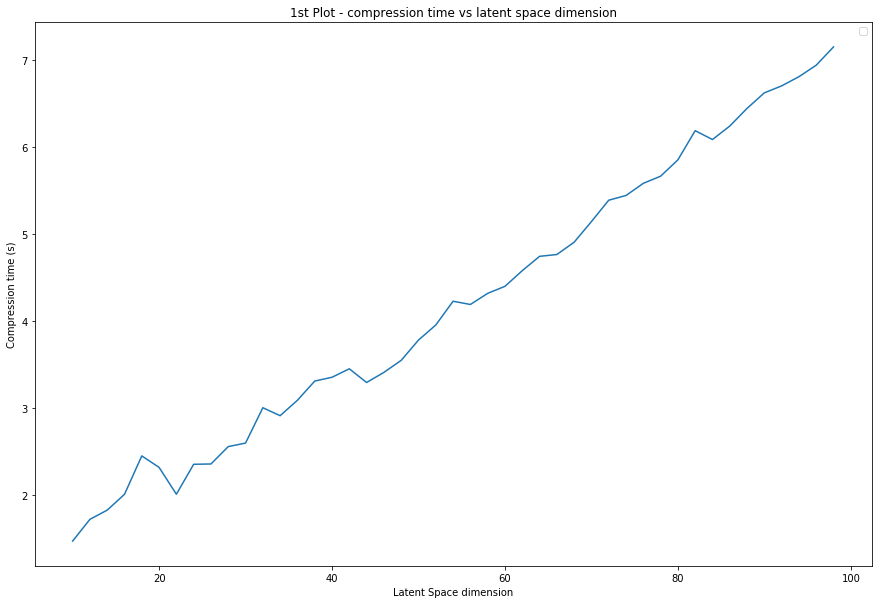

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]


plt.plot(latent_list, file[0])
plt.title('1st Plot - compression time vs latent space dimension')
plt.xlabel('Latent Space dimension')
plt.ylabel('Compression time (s)')
plt.legend()
plt.show()

### We can see for larger latent space dimension, compression time increases.


Then, First hidden layer effects on classification accuracy
So, we setup a different test, this time for second hidden layer of the encoder section of the deep autoencoder.

In [13]:
#   This method cleans the remnant files from the last run
clean()

#   Here, we define the parameters and values to investiate
encoder_i_list = range(10,50,25)
test_params = [{'encoder_i':encoder_i_list}]

#   Perform sensitivity analysis
file = test(test_params)

Train on 95 samples, validate on 32 samples
Epoch 1/50
95/95 [==============================] - 4s 45ms/step - loss: 0.0612 - acc: 0.0000e+00 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 2/50
95/95 [==============================] - 0s 317us/step - loss: 0.0604 - acc: 0.0000e+00 - val_loss: 0.0598 - val_acc: 0.0000e+00
Epoch 3/50
95/95 [==============================] - 0s 210us/step - loss: 0.0595 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 4/50
95/95 [==============================] - 0s 210us/step - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 5/50
95/95 [==============================] - 0s 179us/step - loss: 0.0575 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 6/50
95/95 [==============================] - 0s 200us/step - loss: 0.0564 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 7/50
95/95 [==============================] - 0s 200us/step - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0542

Epoch 10/50
95/95 [==============================] - 0s 164us/step - loss: 0.0553 - acc: 0.0105 - val_loss: 0.0535 - val_acc: 0.0312
Epoch 11/50
95/95 [==============================] - 0s 164us/step - loss: 0.0536 - acc: 0.0105 - val_loss: 0.0518 - val_acc: 0.0312
Epoch 12/50
95/95 [==============================] - 0s 164us/step - loss: 0.0519 - acc: 0.0105 - val_loss: 0.0503 - val_acc: 0.0312
Epoch 13/50
95/95 [==============================] - 0s 164us/step - loss: 0.0502 - acc: 0.0105 - val_loss: 0.0488 - val_acc: 0.0312
Epoch 14/50
95/95 [==============================] - 0s 164us/step - loss: 0.0488 - acc: 0.0105 - val_loss: 0.0474 - val_acc: 0.0312
Epoch 15/50
95/95 [==============================] - 0s 164us/step - loss: 0.0473 - acc: 0.0105 - val_loss: 0.0461 - val_acc: 0.0312
Epoch 16/50
95/95 [==============================] - 0s 164us/step - loss: 0.0459 - acc: 0.0105 - val_loss: 0.0447 - val_acc: 0.0312
Epoch 17/50
95/95 [==============================] - 0s 164us/step - 

# 2nd plot - classification accuracy vs 1st hidden layer dimension

No handles with labels found to put in legend.


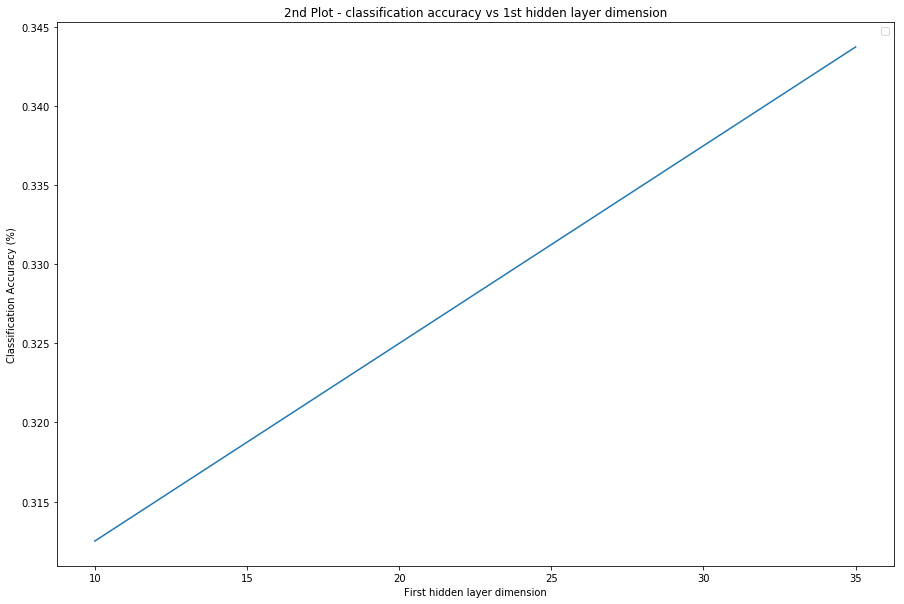

In [14]:
plt.plot(encoder_i_list, file[3])
plt.title('2nd Plot - classification accuracy vs 1st hidden layer dimension')
plt.xlabel('First hidden layer dimension')
plt.ylabel('Classification Accuracy (%)')
plt.legend()
plt.show()

### As it can be seen in the above figure, accuracy increase when 1st hidden layer dimension of the encoder section increases. 

More analysis can be done using the same code to investigate effects of other model parameters on the accuracy or runtime of autoencoder or classifier.